In [5]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [37]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, Sequential
from keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Resizing
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

In [2]:
# Define the custom R2 metric function
def r2_metric(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - (SS_res / (SS_tot + tf.keras.backend.epsilon()))

In [ ]:
#initializing the input and the output data with zeros
X=np.zeros((10000,441))
y=np.zeros((10000,1))

#creating variables for paths to stress directory and volume fraction directory
stress_dir="/kaggle/input/dataset-me504/Q9/Q9/stress_node/" #path to stress directory
vf_dir="/kaggle/input/dataset-me504/Q9/Q9/volume fraction/" #path to volume fraction directory

for i in range(10000):
    print(f"iteration_{i}", end="\r", flush=True) #to see which iteration we are currently on
    X[i]=np.loadtxt(os.path.join(vf_dir + f'prop_{i}' + ".dat")) #loads the data of a volume fraction file on X
    stress=np.loadtxt(os.path.join(stress_dir + f'stress_{i}' + ".txt")) #loads the data of i'th stress file onto this variable
    #next we are extracting the 3 stress components from the file
    tau_x=stress[:,1]
    tau_y=stress[:,2]
    tau_xy=stress[:,3]
    #calulating the maximum vonMises stress out of the 441 nodes and storing the result in y array
    y[i]=max(np.sqrt(tau_x**2 + tau_y**2 - tau_x*tau_y + 3*tau_xy**2)) 

print("successfully loaded data")

#splitting X and y into training(64%), testing(20%) and validation(16%)
X_temp,X_test,y_temp,y_test=train_test_split(X,y,test_size=0.2, random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_temp,y_temp,test_size=0.2, random_state=42)

#calculating the mean and standard deviation of X_train so that the input data set can be normalised
mean=X_train.mean(axis=0)
std=X_train.std(axis=0)+1e-6 #1e-6 is added so that if std comes out as 0 then division by 0 error doesn't occur while normalization

X_train_norm_1d=(X_train-mean)/std #normalizing X_train
X_val_norm_1d=(X_val-mean)/std #normalizing X_val
X_test_norm_1d=(X_test-mean)/std #normalizing X_test

#next we will reshape the normalized training, testing and validation input datasets to (21,21,1) shape to make them suitable for CNN 
X_train_norm=X_train_norm_1d.reshape(-1,21,21,1)
X_val_norm=X_val_norm_1d.reshape(-1,21,21,1)
X_test_norm=X_test_norm_1d.reshape(-1,21,21,1)

In [7]:
#creating the CNN model
model1=keras.Sequential([
    layers.Conv2D(32,(3,3),activation="relu",padding="same",input_shape=(20,20,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu",padding="same"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation="relu",padding="same"),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(32,activation="relu"),
    layers.Dense(1,activation="linear")
])
model1.compile(optimizer="adam", loss="mse", metrics=[r2_metric]) #using mse as loss function and r2 metric with adam optimizer
model1.summary

<bound method Model.summary of <Sequential name=sequential_1, built=True>>

In [8]:
#defining function to predict maximum stress

def build_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # Output: maximum stress prediction
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [9]:
history1=model1.fit(X_train_norm, y_train,batch_size=32, epochs=50, validation_data=(X_val_norm,y_val))

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 32075309447248871424.0000 - r2_metric: -314.7810 - val_loss: 6929375165918740480.0000 - val_r2_metric: -57.5395
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3959105251499311104.0000 - r2_metric: -36.4351 - val_loss: 2942242538393698304.0000 - val_r2_metric: -23.9316
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2850934419898761216.0000 - r2_metric: -26.0676 - val_loss: 2391772591703457792.0000 - val_r2_metric: -19.2221
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2229361392702455808.0000 - r2_metric: -21.0287 - val_loss: 1571641508426153984.0000 - val_r2_metric: -12.3121
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1302192440144297984.0000 - r2_metric: -11.5174 - val_loss: 422397148659712000.0000 - val_r2_metric: -2.5689
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 267828336602906624.0000 - r2_metric: -1.5308 - val_loss: 87660591749005312.0000 - va

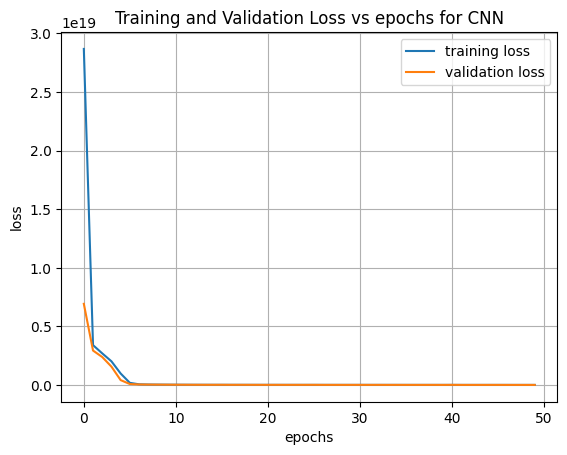

In [10]:
#plotting MSE vs epochs for CNN
plt.plot(history1.history['loss'], label="training loss")
plt.plot(history1.history['val_loss'], label='validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.title("Training and Validation Loss vs epochs for CNN")
plt.show()

In [11]:
#saving the best weights to predict the max stress
CNN_WEIGHTS = "best_cnn.h5"
UNET_WEIGHTS = "best_unet.h5"

In [45]:
#building the model of UNet

def conv_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def build_unet_model(input_shape):
    inputs = layers.Input(input_shape)

    c1 = conv_block(inputs, 16)
    p1 = tf.keras.layers.MaxPooling2D(padding='same')(c1)   # 21 → 11

    c2 = conv_block(p1, 32)
    p2 = tf.keras.layers.MaxPooling2D(padding='same')(c2)   # 11 → 6

    c3 = conv_block(p2, 64)
    p3 = tf.keras.layers.MaxPooling2D(padding='same')(c3)   # 6 → 3

    # Bridge
    c4 = conv_block(p3, 128)

    # Decoder: after each up, crop the 1 extra row/col if needed
    u5 = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(c4)  # 3→6, matches c3(6)
    u5 = tf.keras.layers.concatenate([u5, c3])
    c5 = conv_block(u5, 64)

    u6 = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same')(c5)  # 6→12
    # c2 is 11×11, so we crop 1 row+col off u6
    u6 = tf.keras.layers.Cropping2D(((0,1),(0,1)))(u6)                          # 12→11
    u6 = tf.keras.layers.concatenate([u6, c2])
    c6 = conv_block(u6, 32)

    u7 = tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding='same')(c6)  # 11→22
    # c1 is 21×21, so crop again
    u7 = tf.keras.layers.Cropping2D(((0,1),(0,1)))(u7)                          # 22→21
    u7 = tf.keras.layers.concatenate([u7, c1])
    c7 = conv_block(u7, 16)

    outputs = tf.keras.layers.Conv2D(1, 1, padding='same')(c7)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary
    return model


In [52]:
# Approach 1: CNN
print("Training CNN model for maximum stress prediction...")
cnn_model = build_cnn_model(X_train_norm.shape[1:])
    
cnn_callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('cnn_model.h5', save_best_only=True)
    ]
    
cnn_history = cnn_model.fit(
   X_train_norm, y_train,
   validation_data=(X_val_norm, y_val),
   epochs=50,
   batch_size=32,
   callbacks=cnn_callbacks
   )
    
#Approach 2: UNet
#X_train_padded = np.pad(X_train_norm_1d, ((0, 0), (0, 24*24 - 441)), mode='constant')
#X_train_norm = X_train_padded.reshape(-1, 24, 24, 1)

#print("\nTraining UNet model for stress field prediction...")
#unet_model = build_unet_model(X_train_norm.shape[1:])
    
#unet_callbacks = [
 #   EarlyStopping(patience=10, restore_best_weights=True),
  #  ModelCheckpoint('unet_model.h5', save_best_only=True)
   # ]


    
#unet_history = unet_model.fit(
 #   X_train_norm, y_train,
  #  validation_data=(X_val_norm, y_val),
   # epochs=50,
    #batch_size=16,
 #   callbacks=unet_callbacks
  #  )
    
# Evaluate models
cnn_pred = cnn_model.predict(X_val_norm)
#field_pred = unet_model.predict(X_val)
#max_stress_pred = np.max(field_pred, axis=(1, 2, 3))
    
    # Calculate metrics
cnn_mse = mean_squared_error(y_val, cnn_pred)
cnn_mae = mean_absolute_error(y_val, cnn_pred)
cnn_r2 = r2_score(y_val, cnn_pred)
   
#unet_mse = mean_squared_error(y_val, max_stress_pred)
#unet_mae = mean_absolute_error(y_val, max_stress_pred)
#unet_r2 = r2_score(y_max_val, max_stress_pred)
#print(unet_r2)
    
test_loss_CNN,test_r2_CNN=model1.evaluate(X_test_norm,y_test)
print("For CNN:")
print("R2 score: ",cnn_r2)
print("MSE Loss: ",cnn_mse)
print("MAE Loss: ",cnn_mae)

Training CNN model for maximum stress prediction...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 32678613676432818176.0000 - mae: 5706338816.0000 - val_loss: 32664786218201907200.0000 - val_mae: 5704251392.0000
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 31560526899217170432.0000 - mae: 5607545344.0000 - val_loss: 24054719568297328640.0000 - val_mae: 4891814912.0000
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 17849754339803922432.0000 - mae: 4105246720.0000 - val_loss: 3982344804141891584.0000 - val_mae: 1675334656.0000
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3737900279543103488.0000 - mae: 1629979264.0000 - val_loss: 3438524978654347264.0000 - val_mae: 1556159488.0000
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3410595459163488256.0000 - mae: 1562826112.0000 - val_loss: 3312759540134445056.0000 - val_mae: 1526037888.0000
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3261504156338225152.0000 - mae: 1518162944.0000 - val_loss: 3182791768173182976.0000